In [1]:
import os
import logging

import pandas as pd
import geopandas as gpd

from concurrent.futures import ThreadPoolExecutor, as_completed

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


def process_geojson(file_path, young_threshold, mature_threshold):
    areas, centroid_coords, age_categories = [], [], []
    
    try:
        logging.info(f"Processing file: {file_path}")
        
        gdf = gpd.read_file(file_path)
        
        if gdf.crs is None:
            logging.warning(f"No CRS defined for {file_path}. Skipping file.")
            return [], [], []
        
        if gdf.crs.to_string() != 'EPSG:3067':
            gdf = gdf.to_crs(epsg=3067)
        
        for idx, row in gdf.iterrows():
            geometry = row['geometry']
            
            if geometry is None:
                continue
            
            if geometry.geom_type == 'MultiPolygon':
                for poly in geometry.geoms:
                    area, centroid, category = classify_polygon(poly, young_threshold, mature_threshold)
                    areas.append(area)
                    centroid_coords.append((centroid.x, centroid.y))
                    age_categories.append(category)
            
            elif geometry.geom_type == 'Polygon':
                area, centroid, category = classify_polygon(geometry, young_threshold, mature_threshold)
                areas.append(area)
                centroid_coords.append((centroid.x, centroid.y))
                age_categories.append(category)
    
    except Exception as e:
        logging.error(f"Error processing file {file_path}: {e}")
    
    return areas, centroid_coords, age_categories


def classify_polygon(polygon, young_threshold, mature_threshold):
    area = polygon.area
    centroid = polygon.centroid

    if area < young_threshold:
        category = 'young'
    elif young_threshold <= area < mature_threshold:
        category = 'mature'
    else:
        category = 'old'
    
    return area, centroid, category


def process_geojson_folder(geojson_folder, young_threshold=4, mature_threshold=10, max_workers=4):
    geojson_files = [
        os.path.join(geojson_folder, file) 
        for file in os.listdir(geojson_folder) if file.endswith('.geojson')
    ]
    
    all_areas, all_centroid_coords, all_age_categories = [], [], []
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_geojson, file, young_threshold, mature_threshold) for file in geojson_files]
        
        for future in as_completed(futures):
            try:
                areas, centroid_coords, age_categories = future.result()
                all_areas.extend(areas)
                all_centroid_coords.extend(centroid_coords)
                all_age_categories.extend(age_categories)
            except Exception as e:
                logging.error(f"Error during processing: {e}")
    
    df = pd.DataFrame({
        'x': [coord[0] for coord in all_centroid_coords],
        'y': [coord[1] for coord in all_centroid_coords],
        'area': all_areas,
        'category': all_age_categories
    })
    
    return df


def save_dataframe_to_csv(df, output_file):
    df.to_csv(output_file, index=False)
    logging.info(f"DataFrame saved to {output_file}")


if __name__ == "__main__":
    geojson_folder = "/Users/anisr/Documents/AerialImages/Geojsons/"
    output_file = 'heatmap_data.csv'
    
    heatmap_data = process_geojson_folder(geojson_folder)
    
    save_dataframe_to_csv(heatmap_data, output_file)
    
    print("Combined Heatmap Data:")
    print(heatmap_data.head())

2024-09-11 12:43:58,655 - INFO - Processing file: /Users/anisr/Documents/AerialImages/Geojsons/M5133H_2017_1.geojson
2024-09-11 12:43:58,657 - INFO - Processing file: /Users/anisr/Documents/AerialImages/Geojsons/L4421F_2016.geojson
2024-09-11 12:43:58,657 - INFO - Processing file: /Users/anisr/Documents/AerialImages/Geojsons/U5214H_2018_1.geojson
2024-09-11 12:43:58,659 - INFO - Processing file: /Users/anisr/Documents/AerialImages/Geojsons/P4341G_1.geojson
2024-09-11 12:43:58,949 - INFO - Processing file: /Users/anisr/Documents/AerialImages/Geojsons/N-34-90-A-a-1-3_1.geojson
2024-09-11 12:43:58,991 - INFO - Processing file: /Users/anisr/Documents/AerialImages/Geojsons/N5442C_2014_1.geojson
2024-09-11 12:43:59,011 - INFO - Processing file: /Users/anisr/Documents/AerialImages/Geojsons/63224_1.geojson
2024-09-11 12:43:59,078 - INFO - Processing file: /Users/anisr/Documents/AerialImages/Geojsons/L4134E_2013_1.geojson
2024-09-11 12:43:59,080 - INFO - Processing file: /Users/anisr/Documents/

Combined Heatmap Data:
               x             y       area category
0  416031.643174  6.749871e+06  14.027657      old
1  416314.204532  6.749809e+06   6.083516   mature
2  416312.597657  6.749806e+06   7.214847   mature
3  416632.280953  6.749864e+06  19.500248      old
4  416625.833029  6.749864e+06  12.556957      old


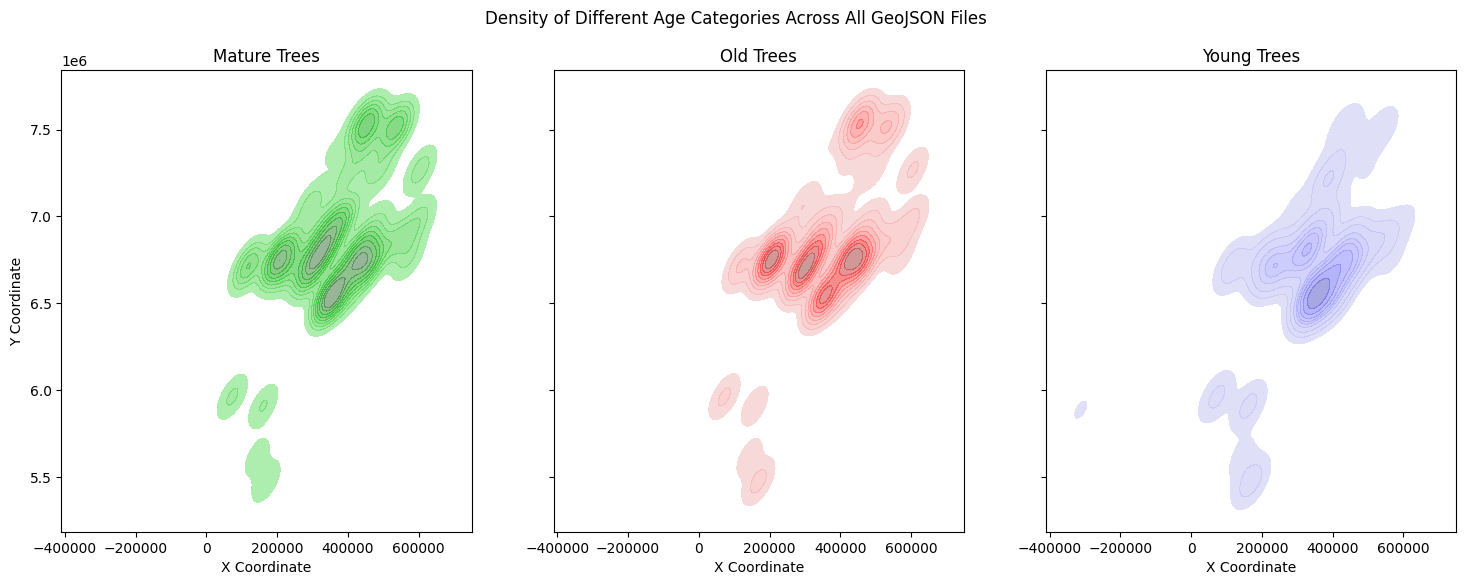

In [295]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

palette = {
    'young': 'blue',
    'mature': 'green',
    'old': 'red'
}

for ax, category in zip(axes, heatmap_data['category'].unique()):
    subset = heatmap_data[heatmap_data['category'] == category]
    sns.kdeplot(
        data=subset,
        x='x',
        y='y',
        fill=True,
        color=palette[category],
        alpha=0.5,
        ax=ax
    )
    ax.set_title(f'{category.capitalize()} Trees')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

plt.suptitle('Density of Different Age Categories Across All GeoJSON Files')
plt.show()

In [296]:
print(f"Total Dead Trees: {len(heatmap_data)}")
heatmap_data['category'].value_counts()

Total Dead Trees: 14876


category
mature    6905
old       6301
young     1670
Name: count, dtype: int64

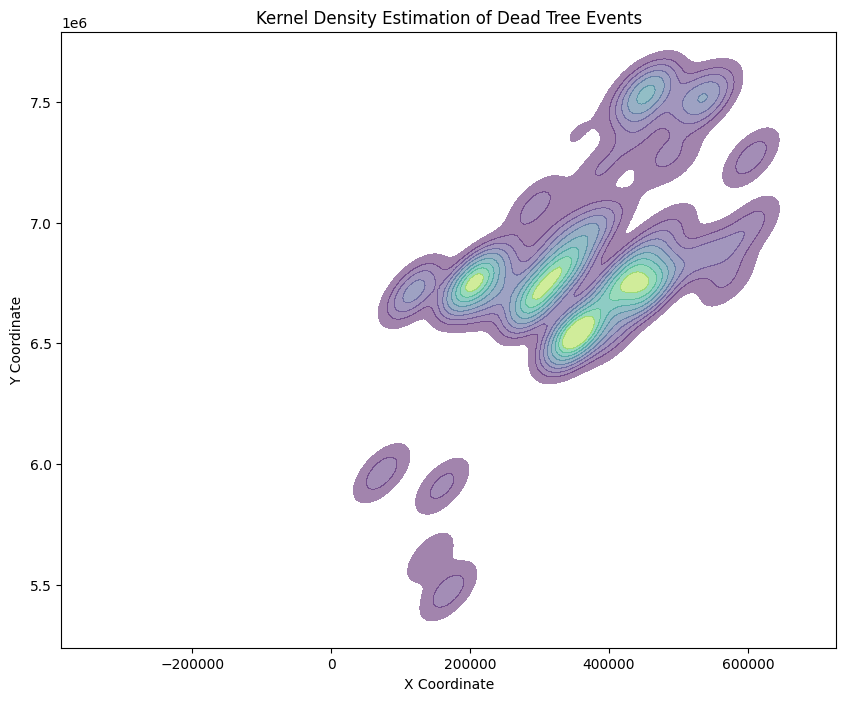

In [297]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 8))

sns.kdeplot(
    data=heatmap_data,
    x='x',
    y='y',
    fill=True,
    cmap='viridis',
    alpha=0.5
)
plt.title('Kernel Density Estimation of Dead Tree Events')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

Number of clustered events: 7674
Number of isolated events: 7202


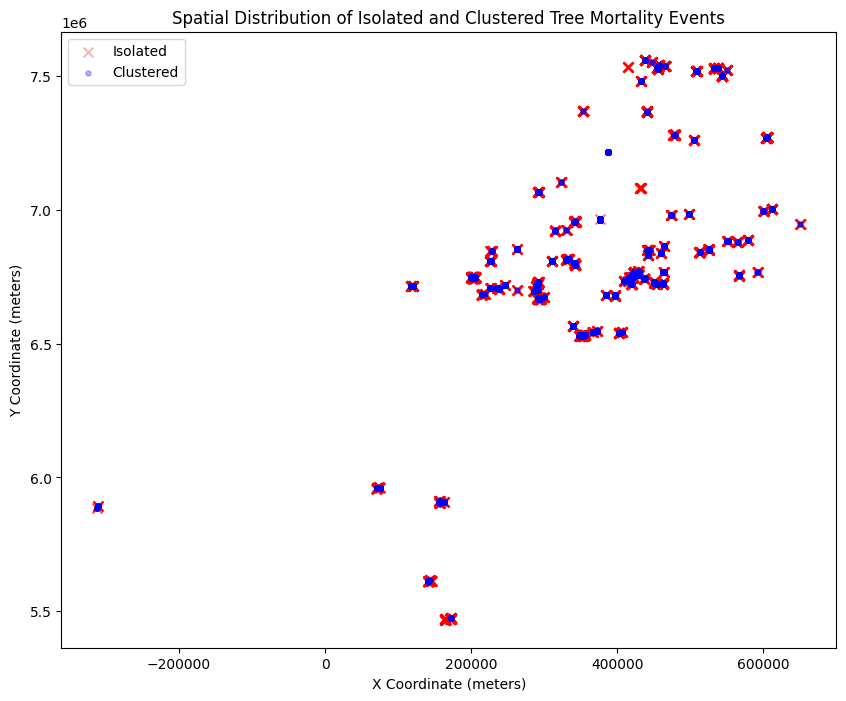

In [338]:
from sklearn.cluster import DBSCAN
import pandas as pd
import matplotlib.pyplot as plt

def find_clusters(df, eps=20, min_samples=3):
    coords = df[['x', 'y']].values
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)

    df['cluster'] = db.labels_
    
    df['event_type'] = df['cluster'].apply(lambda x: 'Isolated' if x == -1 else 'Clustered')

    clustered_count = df[df['event_type'] == 'Clustered'].shape[0]
    isolated_count = df[df['event_type'] == 'Isolated'].shape[0]

    print(f"Number of clustered events: {clustered_count}")
    print(f"Number of isolated events: {isolated_count}")
    
    return heatmap_data


def plot_clusters(heatmap_data):
    plt.figure(figsize=(10, 8))
    
    plt.scatter(
        heatmap_data[heatmap_data['event_type'] == 'Isolated']['x'],
        heatmap_data[heatmap_data['event_type'] == 'Isolated']['y'],
        c='red', label='Isolated', alpha=0.3, s=50, marker='x'
    )
    
    plt.scatter(
        heatmap_data[heatmap_data['event_type'] == 'Clustered']['x'],
        heatmap_data[heatmap_data['event_type'] == 'Clustered']['y'],
        c='blue', label='Clustered', alpha=0.3, s=50, marker='.'
    )
    
    plt.xlabel('X Coordinate (meters)')
    plt.ylabel('Y Coordinate (meters)')
    plt.title('Spatial Distribution of Isolated and Clustered Tree Mortality Events')
    plt.legend()
    plt.show()


heatmap_data = find_clusters(heatmap_data, eps=20, min_samples=3)

plot_clusters(heatmap_data)

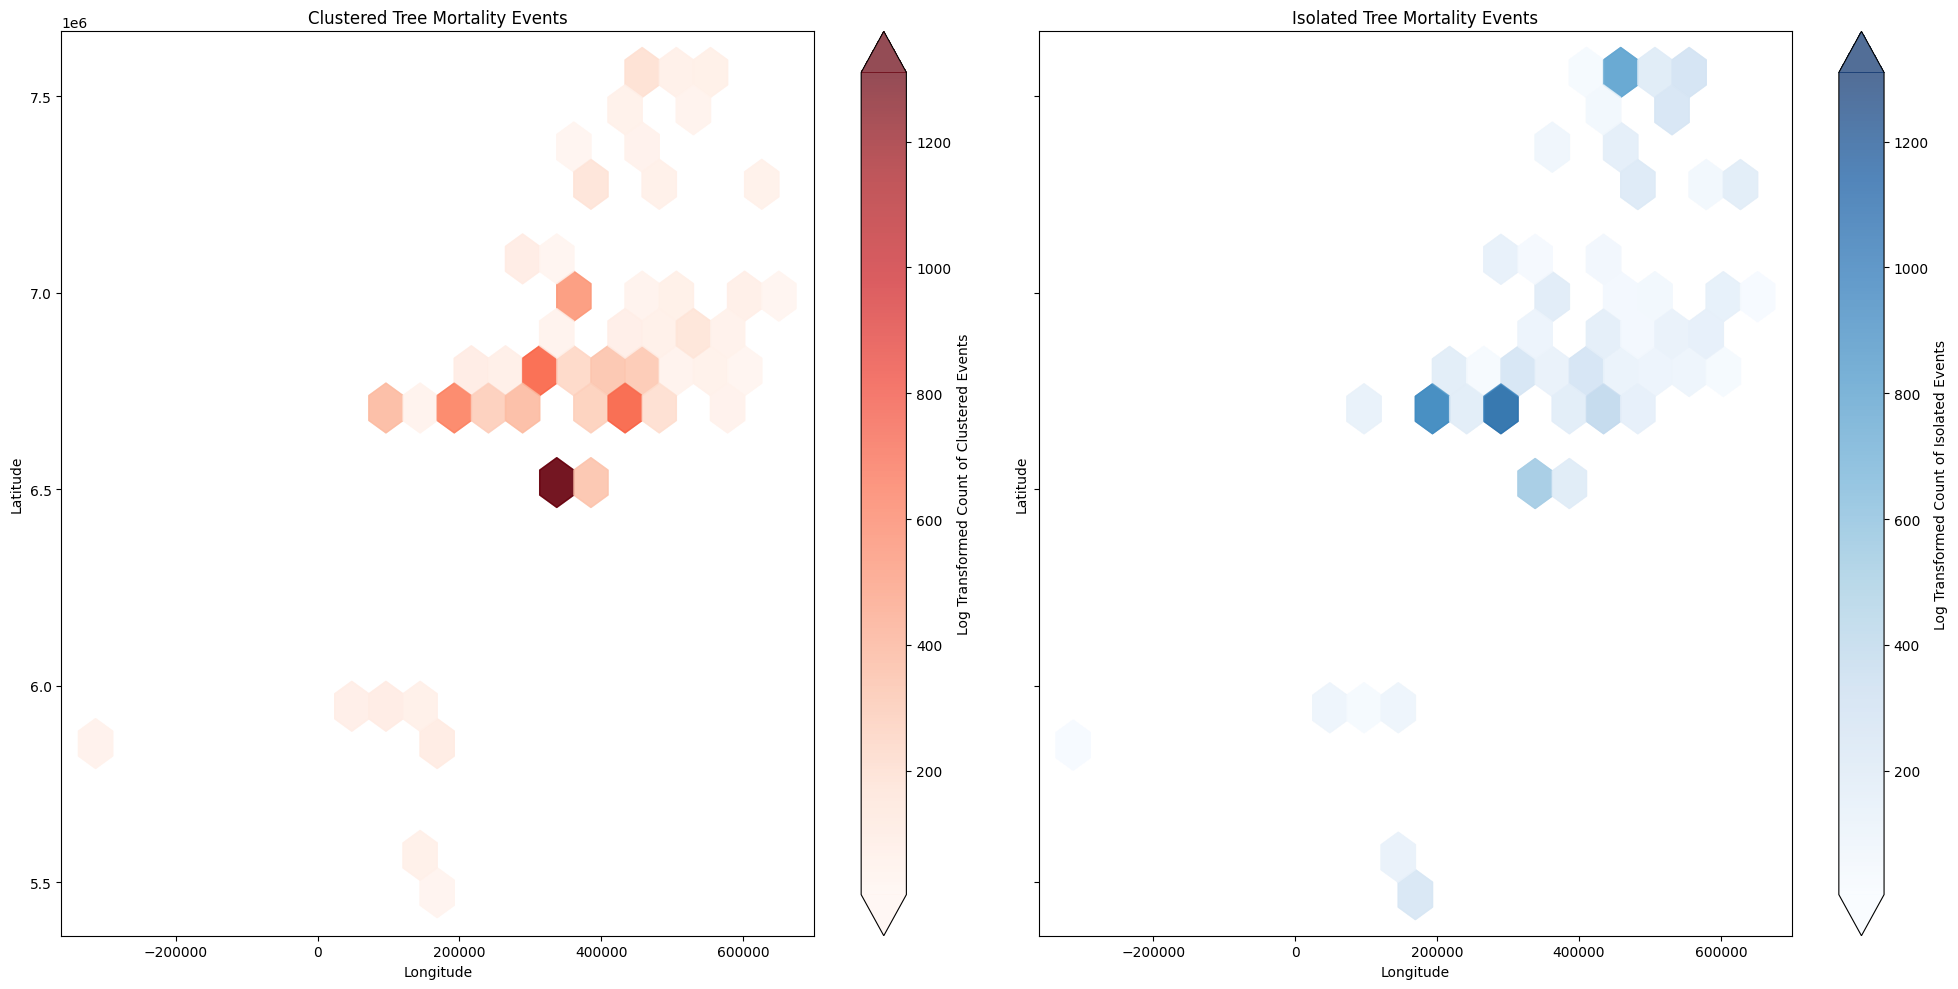

In [299]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


clustered_data = heatmap_data[heatmap_data['event_type'] == 'Clustered']
isolated_data = heatmap_data[heatmap_data['event_type'] == 'Isolated']

fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)

clustered_counts = np.zeros_like(clustered_data['x'].values)  # Placeholder for counts
isolated_counts = np.zeros_like(isolated_data['x'].values)  # Placeholder for counts

hb_clustered = axs[0].hexbin(
    clustered_data['x'],
    clustered_data['y'],
    gridsize=20,
    cmap='Reds',
    mincnt=1,
    alpha=0.7,
    reduce_C_function=np.sum  # Use sum to get counts, which will be log-transformed later
)

hb_isolated = axs[1].hexbin(
    isolated_data['x'],
    isolated_data['y'],
    gridsize=20,
    cmap='Blues',
    mincnt=1,
    alpha=0.7,
    reduce_C_function=np.sum  # Use sum to get counts, which will be log-transformed later
)

counts_clustered = hb_clustered.get_array()
counts_isolated = hb_isolated.get_array()

vmin = min(np.min(counts_clustered), np.min(counts_isolated))
vmax = max(np.max(counts_clustered), np.max(counts_isolated))

hb_clustered = axs[0].hexbin(
    clustered_data['x'],
    clustered_data['y'],
    gridsize=20,
    cmap='Reds',
    mincnt=1,
    alpha=0.7,
    reduce_C_function=np.log1p,  # Apply log transformation
    vmin=vmin,
    vmax=vmax
)

hb_isolated = axs[1].hexbin(
    isolated_data['x'],
    isolated_data['y'],
    gridsize=20,
    cmap='Blues',
    mincnt=1,
    alpha=0.7,
    reduce_C_function=np.log1p,  # Apply log transformation
    vmin=vmin,
    vmax=vmax
)

cbar_clustered = plt.colorbar(hb_clustered, ax=axs[0], extend='both')
cbar_clustered.set_label('Log Transformed Count of Clustered Events')

cbar_isolated = plt.colorbar(hb_isolated, ax=axs[1], extend='both')
cbar_isolated.set_label('Log Transformed Count of Isolated Events')

axs[0].set_title('Clustered Tree Mortality Events')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')

axs[1].set_title('Isolated Tree Mortality Events')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')

plt.tight_layout()
plt.show()

Number of nodes: 14876
Number of edges: 90194


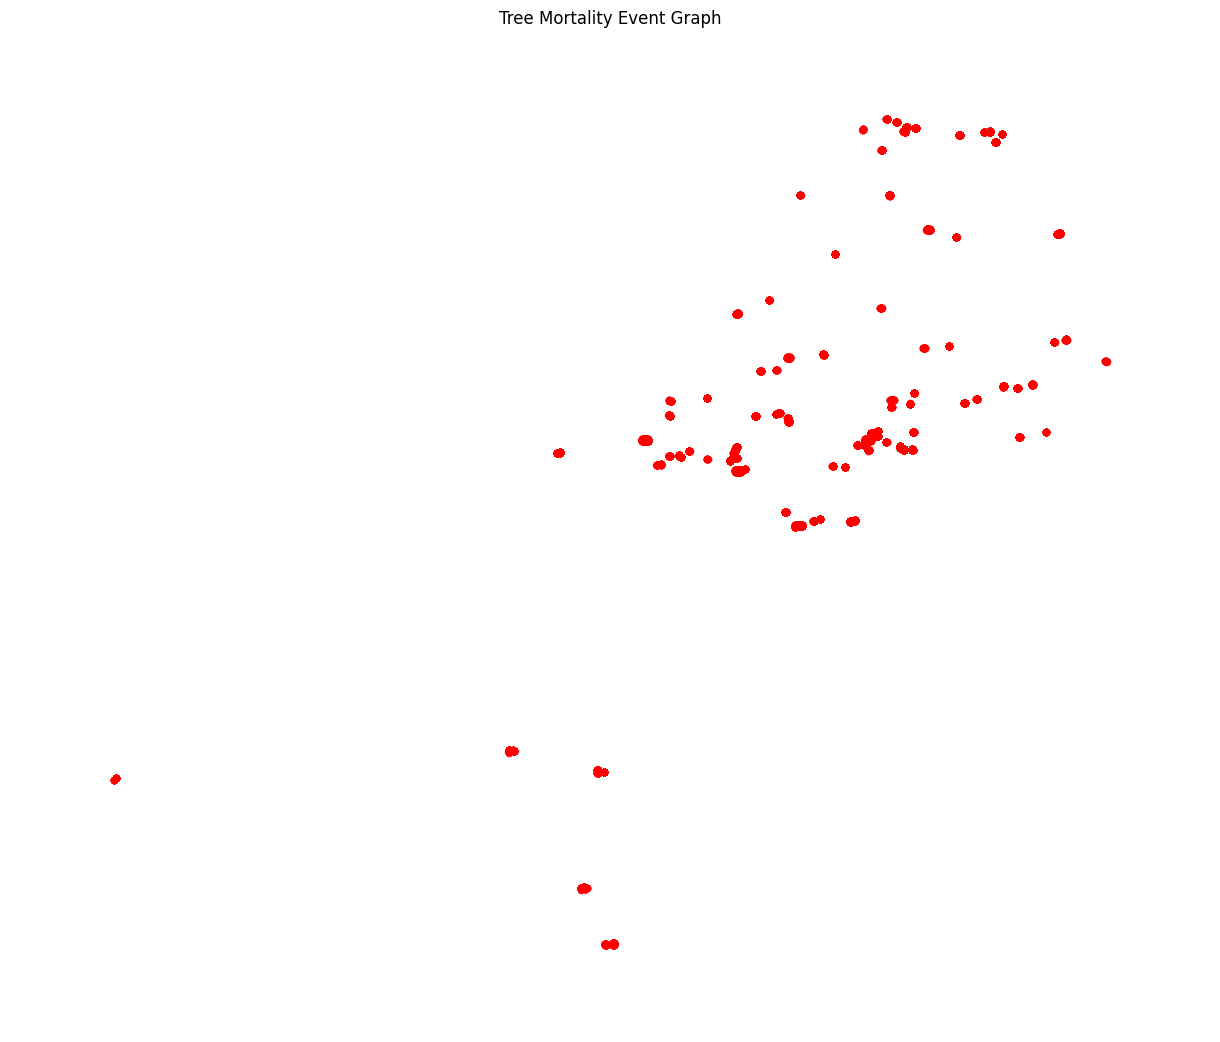

In [7]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import euclidean_distances


def create_graph_from_heatmap_data(df, distance_threshold=50):
    G = nx.Graph()

    for i, row in df.iterrows():
        G.add_node(i, x=row['x'], y=row['y'], area=row['area'], event_type=row['event_type'])

    coords = df[['x', 'y']].values
    distances = euclidean_distances(coords)

    for i in range(len(df)):
        for j in range(i + 1, len(df)):
            if distances[i, j] <= distance_threshold:
                G.add_edge(i, j, weight=distances[i, j])

    return G

G = create_graph_from_heatmap_data(heatmap_data)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

plt.figure(figsize=(12, 10))
pos = {i: (G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes}
nx.draw(G, pos, with_labels=False, node_size=20, node_color='red', edge_color='gray', alpha=0.6)
plt.title('Tree Mortality Event Graph')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

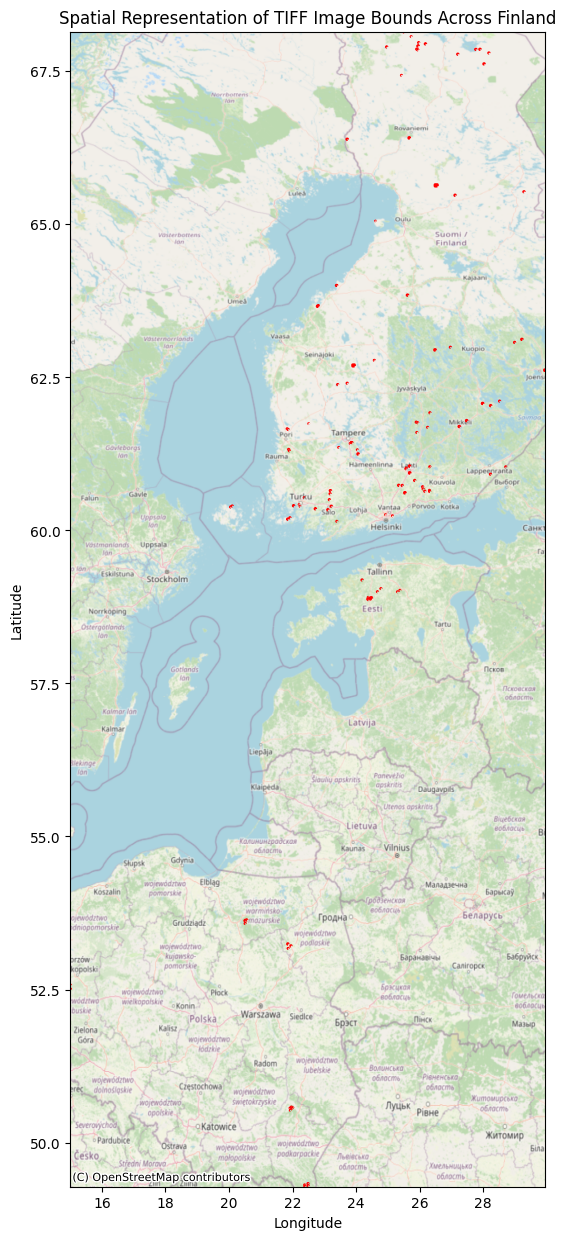

In [21]:
import os
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import contextily as ctx


def plot_bounds_on_map(tiff_folder):
    bounding_boxes = []

    for file_name in os.listdir(tiff_folder):
        if file_name.endswith('.tif') or file_name.endswith('.tiff'):
            file_path = os.path.join(tiff_folder, file_name)
            
            try:
                with rasterio.open(file_path) as src:
                    bounds = src.bounds  # Get the bounding box of the image
                    crs = src.crs  # Get the CRS of the image
                    
                    gdf = gpd.GeoDataFrame({'geometry': [box(bounds.left, bounds.bottom, bounds.right, bounds.top)]}, crs=crs)
                    gdf_wgs84 = gdf.to_crs(epsg=4326)  # Convert to WGS84
                    
                    bounding_boxes.append(gdf_wgs84.geometry.iloc[0])
            except Exception as e:
                print(f"Error reading {file_name}: {e}")

    all_bounds_gdf = gpd.GeoDataFrame(geometry=bounding_boxes, crs='EPSG:4326')

    fig, ax = plt.subplots(figsize=(12, 15))
    all_bounds_gdf.plot(ax=ax, edgecolor='red', linewidth=2, marker='x', markersize=10)

    ctx.add_basemap(ax, crs=all_bounds_gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

    ax.set_xlim(all_bounds_gdf.total_bounds[[0, 2]])
    ax.set_ylim(all_bounds_gdf.total_bounds[[1, 3]])

    plt.title("Spatial Representation of TIFF Image Bounds Across Finland")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()


tiff_folder = '/Users/anisr/Documents/AerialImages/4band_25cm'
plot_bounds_on_map(tiff_folder)

In [4]:
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

from climatepix.climate_fetcher import fetch_climate_data


def fetch_for_coords(coords_df_chunk):
    result = fetch_climate_data(
        coords_df=coords_df_chunk, 
        input_crs="EPSG:3067", 
        period="2017-01-01:2017-12-31", 
        aggregation_level="Monthly",
        climatic_vars=["Tmax", "Tmin", "Prcp"]
    )
    return result


def fetch_climate_data_parallel(df, num_workers=4):
    chunk_size = 100
    coords_chunks = [df.iloc[i:i + chunk_size] for i in range(0, len(df), chunk_size)]
    
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        results = list(executor.map(fetch_for_coords, coords_chunks))
    
    combined_df = pd.concat(results, ignore_index=True)
    return combined_df

df_all_coords = fetch_climate_data_parallel(heatmap_data[['x', 'y']], num_workers=8)
print(df_all_coords)

                    x             y         day    Tmax    Tmin     Prcp
0       416031.643174  6.749871e+06  2017-01-01  -144.0  -718.0   2313.0
1       416031.643174  6.749871e+06  2017-02-01  -125.0  -798.0   2796.0
2       416031.643174  6.749871e+06  2017-03-01   355.0  -326.0   2273.0
3       416031.643174  6.749871e+06  2017-04-01   635.0  -257.0   4752.0
4       416031.643174  6.749871e+06  2017-05-01  1489.0   202.0    935.0
...               ...           ...         ...     ...     ...      ...
178507  450911.721154  6.727549e+06  2017-08-01  1914.0  1183.0   9297.0
178508  450911.721154  6.727549e+06  2017-09-01  1406.0   827.0   7466.0
178509  450911.721154  6.727549e+06  2017-10-01   718.0   327.0  11926.0
178510  450911.721154  6.727549e+06  2017-11-01   404.0    27.0  10073.0
178511  450911.721154  6.727549e+06  2017-12-01   188.0  -121.0  10780.0

[178512 rows x 6 columns]


In [25]:
import pandas as pd


def aggregate_monthly_values(df):
    df['day'] = pd.to_datetime(df['day'])
    df['month'] = df['day'].dt.month

    pivot_df = df.pivot_table(index=['x', 'y'], 
                             columns='month', 
                             values=['Tmax', 'Tmin', 'Prcp'], 
                             aggfunc='first').reset_index()

    pivot_df.columns = ['_'.join(map(str, col)).strip() for col in pivot_df.columns.values]
    
    pivot_df.rename(columns=lambda x: x.replace('Tmax_', 'Tmax_month_').replace('Tmin_', 'Tmin_month_').replace('Prcp_', 'Prcp_month_'), inplace=True)

    pivot_df.rename(columns={'x_': 'x', 'y_': 'y'}, inplace=True)
    
    return pivot_df


result_df = aggregate_monthly_values(df_all_coords)

result_df.to_csv('climate.csv', index=False)

print(result_df.columns)
print(result_df.head())
print(result_df.shape)

Index(['x', 'y', 'Prcp_month_1', 'Prcp_month_2', 'Prcp_month_3',
       'Prcp_month_4', 'Prcp_month_5', 'Prcp_month_6', 'Prcp_month_7',
       'Prcp_month_8', 'Prcp_month_9', 'Prcp_month_10', 'Prcp_month_11',
       'Prcp_month_12', 'Tmax_month_1', 'Tmax_month_2', 'Tmax_month_3',
       'Tmax_month_4', 'Tmax_month_5', 'Tmax_month_6', 'Tmax_month_7',
       'Tmax_month_8', 'Tmax_month_9', 'Tmax_month_10', 'Tmax_month_11',
       'Tmax_month_12', 'Tmin_month_1', 'Tmin_month_2', 'Tmin_month_3',
       'Tmin_month_4', 'Tmin_month_5', 'Tmin_month_6', 'Tmin_month_7',
       'Tmin_month_8', 'Tmin_month_9', 'Tmin_month_10', 'Tmin_month_11',
       'Tmin_month_12'],
      dtype='object')
               x             y  Prcp_month_1  Prcp_month_2  Prcp_month_3  \
0 -312834.108750  5.885802e+06        1613.0        2386.0        2956.0   
1 -312817.563561  5.885811e+06        1606.0        2396.0        2954.0   
2 -312768.933773  5.885738e+06        1606.0        2396.0        2954.0   
3 -31274

In [300]:
import pandas as pd

def reorganize_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df_pivot = df.pivot_table(index=['x', 'y'], columns='month', values='value')
    df_pivot.columns = [f"month_{int(month)}" for month in df_pivot.columns]
    df_pivot = df_pivot.reset_index()
    return df_pivot

reorganized_df = reorganize_dataframe(df_all_coords)
print(reorganized_df.shape)
print(reorganized_df.head())

(14876, 14)
               x             y  month_1  month_2  month_3  month_4  month_5  \
0 -312834.108750  5.885802e+06   1613.0   2386.0   2956.0   2077.0   6576.0   
1 -312817.563561  5.885811e+06   1606.0   2396.0   2954.0   2080.0   6622.0   
2 -312768.933773  5.885738e+06   1606.0   2396.0   2954.0   2080.0   6622.0   
3 -312743.807809  5.885781e+06   1606.0   2396.0   2954.0   2080.0   6622.0   
4 -312743.737396  5.885779e+06   1606.0   2396.0   2954.0   2080.0   6622.0   

   month_6  month_7  month_8  month_9  month_10  month_11  month_12  
0   9016.0   8777.0   5581.0   2788.0    6389.0    4374.0    3036.0  
1   8948.0   8766.0   5556.0   2731.0    6201.0    4338.0    3010.0  
2   8948.0   8766.0   5556.0   2731.0    6201.0    4338.0    3010.0  
3   8948.0   8766.0   5556.0   2731.0    6201.0    4338.0    3010.0  
4   8948.0   8766.0   5556.0   2731.0    6201.0    4338.0    3010.0  


In [ ]:
def flatten_for_daily(coords, days_of_years):
    coords_flat, days_flat = [], []
    for coord in coords:
        for days in days_of_years:
            coords_flat.extend([coord] * len(days))
            days_flat.extend(days)
    return coords_flat, days_flat

def flatten_for_daily(coords, days_of_years):

In [6]:
import pandas as pd
import requests
import time
from pyproj import Transformer
from geopy.distance import geodesic
from tqdm import tqdm  # Import tqdm for progress bar

# Convert EPSG:3067 (ETRS89 / TM35FIN) to WGS84 (latitude/longitude)
def convert_epsg3067_to_wgs84(x, y):
    transformer = Transformer.from_crs("EPSG:3067", "EPSG:4326", always_xy=True)
    return transformer.transform(x, y)

# Check if two coordinates are within 30 meters
def are_coordinates_close(coord1, coord2, threshold=30):
    return geodesic(coord1, coord2).meters < threshold

# Query Open Elevation API for a batch of coordinates, with retry mechanism
def get_elevations_batch_with_retry(coordinates, max_retries=3, retry_delay=5):
    url = "https://api.open-elevation.com/api/v1/lookup"
    locations = [{"latitude": lat, "longitude": lon} for lat, lon in coordinates]
    data = {"locations": locations}
    
    retries = 0
    while retries < max_retries:
        try:
            response = requests.post(url, json=data)
            
            if response.status_code == 200:
                return response.json()["results"]
            elif response.status_code == 504:
                print(f"504 Error: Retrying in {retry_delay} seconds... ({retries+1}/{max_retries})")
                time.sleep(retry_delay)
                retry_delay *= 2  # Exponential backoff
                retries += 1
            else:
                print(f"Error: {response.status_code}")
                return None
        except requests.exceptions.RequestException as e:
            print(f"Request failed: {e}")
            return None
    print("Max retries exceeded. Could not fetch elevations.")
    return None

# Get elevation with batching and caching, with tqdm progress tracking
def get_elevations(df, batch_size=50):
    elevation_cache = {}
    results = []
    batch_coords = []
    row_indices = []  # Keep track of row indices for each batch
    
    # Add tqdm progress bar around the dataframe iteration
    for i, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Coordinates"):
        x, y = row['x'], row['y']

        # Convert to WGS84
        lat, lon = convert_epsg3067_to_wgs84(x, y)
        coord = (lat, lon)

        # Check if the coordinate (or nearby) has already been queried
        for cached_coord in elevation_cache:
            if are_coordinates_close(coord, cached_coord):
                results.append(elevation_cache[cached_coord])
                break
        else:
            # If not in cache, add to the current batch
            batch_coords.append(coord)
            row_indices.append(i)  # Keep track of which row this corresponds to
            
            # When the batch is full, query the API
            if len(batch_coords) >= batch_size:
                batch_results = get_elevations_batch_with_retry(batch_coords)

                if batch_results:
                    for j, result in enumerate(batch_results):
                        elevation_cache[batch_coords[j]] = result["elevation"]
                        # Append the result to the correct row based on row_indices
                        results.append(result["elevation"])

                # Clear the batch for the next set of coordinates
                batch_coords.clear()
                row_indices.clear()

                # Throttle the requests to avoid hitting API limits
                time.sleep(2)  # Adjust the delay depending on rate limits

    # Process any remaining coordinates in the batch (if less than batch_size)
    if batch_coords:
        batch_results = get_elevations_batch_with_retry(batch_coords)

        if batch_results:
            for j, result in enumerate(batch_results):
                elevation_cache[batch_coords[j]] = result["elevation"]
                results.append(result["elevation"])

    # Add the elevations to the dataframe
    df['elevation'] = pd.Series(results)
    return df

df = heatmap_data[['x','y']]

# Get elevations for the dataframe with a batch size of 2 (for demonstration)
df_with_elevations = get_elevations(df, batch_size=5)
print(df_with_elevations)

Processing Coordinates:   2%|▏         | 331/14876 [02:17<1:19:50,  3.04it/s]

504 Error: Retrying in 5 seconds... (1/3)


Processing Coordinates:   2%|▏         | 331/14876 [02:30<1:19:50,  3.04it/s]

504 Error: Retrying in 10 seconds... (2/3)
504 Error: Retrying in 20 seconds... (3/3)
Max retries exceeded. Could not fetch elevations.


Processing Coordinates:   2%|▏         | 338/14876 [03:10<13:05:43,  3.24s/it]

504 Error: Retrying in 5 seconds... (1/3)
504 Error: Retrying in 10 seconds... (2/3)


Processing Coordinates:   3%|▎         | 395/14876 [04:01<1:40:58,  2.39it/s] 

504 Error: Retrying in 5 seconds... (1/3)


Processing Coordinates:  12%|█▏        | 1715/14876 [11:36<1:05:59,  3.32it/s]

504 Error: Retrying in 5 seconds... (1/3)


Processing Coordinates:  12%|█▏        | 1763/14876 [12:01<33:15,  6.57it/s]   

504 Error: Retrying in 5 seconds... (1/3)


Processing Coordinates:  19%|█▉        | 2810/14876 [19:41<7:16:12,  2.17s/it] 

504 Error: Retrying in 5 seconds... (1/3)
504 Error: Retrying in 10 seconds... (2/3)
504 Error: Retrying in 20 seconds... (3/3)
Max retries exceeded. Could not fetch elevations.


Processing Coordinates:  19%|█▉        | 2819/14876 [20:35<3:50:41,  1.15s/it] 

504 Error: Retrying in 5 seconds... (1/3)
504 Error: Retrying in 10 seconds... (2/3)
504 Error: Retrying in 20 seconds... (3/3)
Max retries exceeded. Could not fetch elevations.


Processing Coordinates:  19%|█▉        | 2824/14876 [21:28<13:44:28,  4.10s/it]

504 Error: Retrying in 5 seconds... (1/3)
504 Error: Retrying in 10 seconds... (2/3)
504 Error: Retrying in 20 seconds... (3/3)
Max retries exceeded. Could not fetch elevations.


Processing Coordinates:  19%|█▉        | 2829/14876 [22:22<15:22:41,  4.60s/it]

504 Error: Retrying in 5 seconds... (1/3)
504 Error: Retrying in 10 seconds... (2/3)
504 Error: Retrying in 20 seconds... (3/3)
Max retries exceeded. Could not fetch elevations.


Processing Coordinates:  22%|██▏       | 3253/14876 [26:02<38:17,  5.06it/s]   

504 Error: Retrying in 5 seconds... (1/3)


Processing Coordinates:  33%|███▎      | 4975/14876 [39:29<42:34,  3.88it/s]   

504 Error: Retrying in 5 seconds... (1/3)


Processing Coordinates:  38%|███▊      | 5596/14876 [44:55<37:22,  4.14it/s]   

504 Error: Retrying in 5 seconds... (1/3)


Processing Coordinates:  49%|████▊     | 7223/14876 [1:00:06<40:59,  3.11it/s]  

504 Error: Retrying in 5 seconds... (1/3)
504 Error: Retrying in 10 seconds... (2/3)
504 Error: Retrying in 20 seconds... (3/3)
Max retries exceeded. Could not fetch elevations.


Processing Coordinates:  49%|████▊     | 7230/14876 [1:01:01<4:37:21,  2.18s/it] 

504 Error: Retrying in 5 seconds... (1/3)
504 Error: Retrying in 10 seconds... (2/3)


Processing Coordinates:  56%|█████▌    | 8275/14876 [1:12:06<52:54,  2.08it/s]   

504 Error: Retrying in 5 seconds... (1/3)
504 Error: Retrying in 10 seconds... (2/3)


Processing Coordinates:  59%|█████▉    | 8820/14876 [1:18:32<53:52,  1.87it/s]   

504 Error: Retrying in 5 seconds... (1/3)


Processing Coordinates:  60%|█████▉    | 8876/14876 [1:19:22<55:55,  1.79it/s]  

504 Error: Retrying in 5 seconds... (1/3)
504 Error: Retrying in 10 seconds... (2/3)
504 Error: Retrying in 20 seconds... (3/3)
Max retries exceeded. Could not fetch elevations.


Processing Coordinates:  60%|█████▉    | 8881/14876 [1:20:16<6:58:32,  4.19s/it] 

504 Error: Retrying in 5 seconds... (1/3)
504 Error: Retrying in 10 seconds... (2/3)
504 Error: Retrying in 20 seconds... (3/3)
Max retries exceeded. Could not fetch elevations.


Processing Coordinates:  60%|█████▉    | 8886/14876 [1:21:11<8:00:55,  4.82s/it] 

504 Error: Retrying in 5 seconds... (1/3)
504 Error: Retrying in 10 seconds... (2/3)
504 Error: Retrying in 20 seconds... (3/3)
Max retries exceeded. Could not fetch elevations.


Processing Coordinates:  60%|█████▉    | 8893/14876 [1:22:06<4:17:28,  2.58s/it] 

504 Error: Retrying in 5 seconds... (1/3)
504 Error: Retrying in 10 seconds... (2/3)
504 Error: Retrying in 20 seconds... (3/3)
Max retries exceeded. Could not fetch elevations.


Processing Coordinates:  68%|██████▊   | 10156/14876 [1:38:02<35:07,  2.24it/s]  

504 Error: Retrying in 5 seconds... (1/3)


Processing Coordinates:  69%|██████▊   | 10221/14876 [1:39:02<35:42,  2.17it/s]  

504 Error: Retrying in 5 seconds... (1/3)


Processing Coordinates:  69%|██████▉   | 10228/14876 [1:39:17<1:08:15,  1.13it/s]

504 Error: Retrying in 5 seconds... (1/3)
504 Error: Retrying in 10 seconds... (2/3)


Processing Coordinates:  70%|██████▉   | 10408/14876 [1:43:04<42:44,  1.74it/s]   

504 Error: Retrying in 5 seconds... (1/3)


Processing Coordinates:  70%|██████▉   | 10413/14876 [1:43:18<1:40:28,  1.35s/it]

504 Error: Retrying in 5 seconds... (1/3)


Processing Coordinates:  74%|███████▍  | 11002/14876 [1:51:37<39:37,  1.63it/s]  

504 Error: Retrying in 5 seconds... (1/3)


Processing Coordinates:  74%|███████▍  | 11020/14876 [1:52:03<39:02,  1.65it/s]  

504 Error: Retrying in 5 seconds... (1/3)


Processing Coordinates:  74%|███████▍  | 11076/14876 [1:53:03<38:40,  1.64it/s]  

504 Error: Retrying in 5 seconds... (1/3)


Processing Coordinates:  78%|███████▊  | 11560/14876 [2:00:21<28:50,  1.92it/s]  

504 Error: Retrying in 5 seconds... (1/3)
504 Error: Retrying in 10 seconds... (2/3)
504 Error: Retrying in 20 seconds... (3/3)
Max retries exceeded. Could not fetch elevations.


Processing Coordinates:  78%|███████▊  | 11567/14876 [2:01:17<2:09:04,  2.34s/it] 

504 Error: Retrying in 5 seconds... (1/3)
504 Error: Retrying in 10 seconds... (2/3)
504 Error: Retrying in 20 seconds... (3/3)
Max retries exceeded. Could not fetch elevations.


Processing Coordinates:  78%|███████▊  | 11631/14876 [2:03:04<33:48,  1.60it/s]   

504 Error: Retrying in 5 seconds... (1/3)


Processing Coordinates:  79%|███████▊  | 11685/14876 [2:04:03<27:55,  1.90it/s]  

504 Error: Retrying in 5 seconds... (1/3)


Processing Coordinates:  79%|███████▊  | 11711/14876 [2:04:33<27:33,  1.91it/s]  

504 Error: Retrying in 5 seconds... (1/3)


Processing Coordinates:  80%|███████▉  | 11876/14876 [2:07:02<27:42,  1.80it/s]  

504 Error: Retrying in 5 seconds... (1/3)


Processing Coordinates:  81%|████████▏ | 12095/14876 [2:20:10<17:10:11, 22.23s/it]  

504 Error: Retrying in 5 seconds... (1/3)
504 Error: Retrying in 10 seconds... (2/3)
504 Error: Retrying in 20 seconds... (3/3)
Max retries exceeded. Could not fetch elevations.


Processing Coordinates:  81%|████████▏ | 12103/14876 [2:21:07<2:22:24,  3.08s/it] 

504 Error: Retrying in 5 seconds... (1/3)
504 Error: Retrying in 10 seconds... (2/3)
504 Error: Retrying in 20 seconds... (3/3)
Max retries exceeded. Could not fetch elevations.


Processing Coordinates:  81%|████████▏ | 12109/14876 [2:22:03<2:40:23,  3.48s/it] 

504 Error: Retrying in 5 seconds... (1/3)
504 Error: Retrying in 10 seconds... (2/3)


Processing Coordinates:  85%|████████▌ | 12709/14876 [3:00:56<24:24,  1.48it/s]     

504 Error: Retrying in 5 seconds... (1/3)
504 Error: Retrying in 10 seconds... (2/3)
504 Error: Retrying in 20 seconds... (3/3)
Max retries exceeded. Could not fetch elevations.


Processing Coordinates:  88%|████████▊ | 13157/14876 [3:10:59<19:42,  1.45it/s]   

504 Error: Retrying in 5 seconds... (1/3)
504 Error: Retrying in 10 seconds... (2/3)


Processing Coordinates:  93%|█████████▎| 13770/14876 [3:19:28<07:52,  2.34it/s]  

504 Error: Retrying in 5 seconds... (1/3)
504 Error: Retrying in 10 seconds... (2/3)
504 Error: Retrying in 20 seconds... (3/3)
Max retries exceeded. Could not fetch elevations.


Processing Coordinates:  93%|█████████▎| 13777/14876 [3:20:23<40:17,  2.20s/it]  

504 Error: Retrying in 5 seconds... (1/3)
504 Error: Retrying in 10 seconds... (2/3)
504 Error: Retrying in 20 seconds... (3/3)
Max retries exceeded. Could not fetch elevations.


Processing Coordinates:  93%|█████████▎| 13784/14876 [3:21:18<42:33,  2.34s/it]  

504 Error: Retrying in 5 seconds... (1/3)
504 Error: Retrying in 10 seconds... (2/3)
504 Error: Retrying in 20 seconds... (3/3)
Max retries exceeded. Could not fetch elevations.


Processing Coordinates:  93%|█████████▎| 13795/14876 [3:22:14<14:43,  1.22it/s]  

504 Error: Retrying in 5 seconds... (1/3)
504 Error: Retrying in 10 seconds... (2/3)
504 Error: Retrying in 20 seconds... (3/3)
Max retries exceeded. Could not fetch elevations.


Processing Coordinates:  93%|█████████▎| 13802/14876 [3:23:09<39:58,  2.23s/it]  

504 Error: Retrying in 5 seconds... (1/3)
504 Error: Retrying in 10 seconds... (2/3)
504 Error: Retrying in 20 seconds... (3/3)
Max retries exceeded. Could not fetch elevations.


Processing Coordinates:  93%|█████████▎| 13808/14876 [3:24:04<57:08,  3.21s/it]  

504 Error: Retrying in 5 seconds... (1/3)
504 Error: Retrying in 10 seconds... (2/3)
504 Error: Retrying in 20 seconds... (3/3)
Max retries exceeded. Could not fetch elevations.


Processing Coordinates:  93%|█████████▎| 13813/14876 [3:24:58<1:21:48,  4.62s/it]

504 Error: Retrying in 5 seconds... (1/3)
504 Error: Retrying in 10 seconds... (2/3)


Processing Coordinates:  94%|█████████▎| 13917/14876 [3:26:35<08:32,  1.87it/s]  

504 Error: Retrying in 5 seconds... (1/3)


Processing Coordinates:  94%|█████████▍| 13952/14876 [3:27:38<29:14,  1.90s/it]  

Request failed: HTTPSConnectionPool(host='api.open-elevation.com', port=443): Max retries exceeded with url: /api/v1/lookup (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x17a413770>: Failed to resolve 'api.open-elevation.com' ([Errno 8] nodename nor servname provided, or not known)"))


Processing Coordinates:  94%|█████████▍| 14033/14876 [3:37:35<05:08,  2.73it/s]    

504 Error: Retrying in 5 seconds... (1/3)


Processing Coordinates:  96%|█████████▋| 14333/14876 [3:40:47<03:16,  2.76it/s]  

504 Error: Retrying in 5 seconds... (1/3)


Processing Coordinates: 100%|██████████| 14876/14876 [3:46:35<00:00,  1.09it/s]


                   x             y  elevation
0      543538.742616  7.501162e+06       47.0
1      592322.541667  6.768069e+06     2142.0
2      592237.800000  6.768107e+06     2082.0
3      592241.419942  6.768152e+06     2082.0
4      416031.643174  6.749871e+06       29.0
...              ...           ...        ...
14871  423216.000000  6.765964e+06        NaN
14872  423127.567235  6.765961e+06        NaN
14873  423108.782238  6.765967e+06        NaN
14874  423030.994012  6.765968e+06        NaN
14875  422949.471184  6.765972e+06        NaN

[14876 rows x 3 columns]


/var/folders/b1/qgbsvl0n4hlf_mxy5hyf7_740000gn/T/ipykernel_43304/2126446192.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elevation'] = pd.Series(results)


In [301]:
heatmap_data_with_elevation = pd.merge(heatmap_data, df_with_elevations, on=['x', 'y'], how='outer')

print(heatmap_data.shape)

heatmap_data_with_elevation.head()

(14876, 6)


,x,y,area,category,cluster,event_type,elevation
0,-312834.108750,5.885802e+06,14.546609,old,-1,Isolated,0.0
1,-312817.563561,5.885811e+06,7.183616,mature,-1,Isolated,0.0
2,-312768.933773,5.885738e+06,42.753360,old,-1,Isolated,0.0
3,-312743.807809,5.885781e+06,2.703480,young,916,Clustered,336.0
4,-312743.737396,5.885779e+06,6.238810,mature,916,Clustered,45.0


In [302]:
# 3

import pandas as pd
import numpy as np
from scipy.spatial import cKDTree

def compute_nearest_neighbor_distance(df: pd.DataFrame) -> pd.DataFrame:
    # Extract x and y coordinates
    coords = df[['x', 'y']].values

    # Build a KDTree with the coordinates
    tree = cKDTree(coords)

    # Query the tree for the distance to the nearest neighbor for each point
    distances, _ = tree.query(coords, k=2)  # k=2 because the first nearest neighbor is the point itself
    
    # Add the second nearest neighbor's distance (index 1) as a new column
    df['nearest_neighbor_distance'] = distances[:, 1]

    return df

# Compute the nearest neighbor distances and add as a feature
heatmap_data_with_distances = compute_nearest_neighbor_distance(heatmap_data_with_elevation)
print(heatmap_data_with_elevation.shape)

heatmap_data_with_distances.head()

(14876, 8)


,x,y,area,category,cluster,event_type,elevation,nearest_neighbor_distance
0,-312834.108750,5.885802e+06,14.546609,old,-1,Isolated,0.0,18.753346
1,-312817.563561,5.885811e+06,7.183616,mature,-1,Isolated,0.0,18.753346
2,-312768.933773,5.885738e+06,42.753360,old,-1,Isolated,0.0,47.401661
3,-312743.807809,5.885781e+06,2.703480,young,916,Clustered,336.0,2.727481
4,-312743.737396,5.885779e+06,6.238810,mature,916,Clustered,45.0,2.727481


In [303]:
# 4

import pandas as pd
import numpy as np
from scipy.spatial import cKDTree

def compute_density_within_radius(df: pd.DataFrame, radius: float) -> pd.DataFrame:
    # Extract x and y coordinates
    coords = df[['x', 'y']].values
    
    # Build a KDTree with the coordinates
    tree = cKDTree(coords)
    
    # Query the tree for all points within the given radius
    neighbors_within_radius = tree.query_ball_point(coords, r=radius)
    
    # Compute density (points per unit area)
    area = np.pi * radius**2
    densities = [len(neighbors) / area for neighbors in neighbors_within_radius]

    # Add density as a new column
    df[f'density_within_{radius}m'] = densities

    return df

# Compute the density within a 10 meter radius and add as a feature
heatmap_data_with_density = compute_density_within_radius(heatmap_data_with_distances, radius=10)

# Compute the density within a 20 meter radius and add as a feature
heatmap_data_with_density = compute_density_within_radius(heatmap_data_with_density, radius=20)

print(heatmap_data_with_density.shape)
heatmap_data_with_density.head()

(14876, 10)


,x,y,area,category,cluster,event_type,elevation,nearest_neighbor_distance,density_within_10m,density_within_20m
0,-312834.108750,5.885802e+06,14.546609,old,-1,Isolated,0.0,18.753346,0.003183,0.001592
1,-312817.563561,5.885811e+06,7.183616,mature,-1,Isolated,0.0,18.753346,0.003183,0.001592
2,-312768.933773,5.885738e+06,42.753360,old,-1,Isolated,0.0,47.401661,0.003183,0.000796
3,-312743.807809,5.885781e+06,2.703480,young,916,Clustered,336.0,2.727481,0.012732,0.003979
4,-312743.737396,5.885779e+06,6.238810,mature,916,Clustered,45.0,2.727481,0.012732,0.003979


In [304]:
# 5

import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull

def compute_dbscan_clustering(df: pd.DataFrame, eps: float = 10, min_samples: int = 5) -> pd.DataFrame:
    # Extract x and y coordinates
    coords = df[['x', 'y']].values

    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(coords)

    # Add cluster ID as a new column
    df['cluster_id'] = cluster_labels

    # Calculate cluster size (number of points in each cluster)
    cluster_sizes = df.groupby('cluster_id').size().to_dict()
    df['cluster_size'] = df['cluster_id'].map(cluster_sizes)

    # Calculate average cluster area (using convex hulls to approximate the area)
    def calculate_cluster_area(cluster_coords):
        if len(cluster_coords) > 2:
            hull = ConvexHull(cluster_coords)
            return hull.area
        return 0  # Not enough points to form a convex hull

    cluster_areas = df.groupby('cluster_id').apply(lambda x: calculate_cluster_area(x[['x', 'y']].values)).to_dict()
    df['cluster_area'] = df['cluster_id'].map(cluster_areas)

    # Add average cluster area
    df['average_cluster_area'] = df['cluster_area'] / df['cluster_size']

    return df

# Apply DBSCAN clustering and add cluster-related features
heatmap_data_with_clusters = compute_dbscan_clustering(heatmap_data_with_density, eps=10, min_samples=5)

print(heatmap_data_with_clusters.shape)
heatmap_data_with_clusters.head()

(14876, 14)


/var/folders/b1/qgbsvl0n4hlf_mxy5hyf7_740000gn/T/ipykernel_43304/3519888689.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_areas = df.groupby('cluster_id').apply(lambda x: calculate_cluster_area(x[['x', 'y']].values)).to_dict()


,x,y,area,category,cluster,event_type,elevation,nearest_neighbor_distance,density_within_10m,density_within_20m,cluster_id,cluster_size,cluster_area,average_cluster_area
0,-312834.108750,5.885802e+06,14.546609,old,-1,Isolated,0.0,18.753346,0.003183,0.001592,-1,12002,4.733887e+06,394.42485
1,-312817.563561,5.885811e+06,7.183616,mature,-1,Isolated,0.0,18.753346,0.003183,0.001592,-1,12002,4.733887e+06,394.42485
2,-312768.933773,5.885738e+06,42.753360,old,-1,Isolated,0.0,47.401661,0.003183,0.000796,-1,12002,4.733887e+06,394.42485
3,-312743.807809,5.885781e+06,2.703480,young,916,Clustered,336.0,2.727481,0.012732,0.003979,-1,12002,4.733887e+06,394.42485
4,-312743.737396,5.885779e+06,6.238810,mature,916,Clustered,45.0,2.727481,0.012732,0.003979,-1,12002,4.733887e+06,394.42485


In [308]:
mismatches_x = heatmap_data_with_clusters['x'] != reorganized_df['x']
mismatches_y = heatmap_data_with_clusters['y'] != reorganized_df['y']

total_mismatches = mismatches_x | mismatches_y

num_mismatches = total_mismatches.sum()

print(f"Number of mismatches: {num_mismatches}")

mismatched_rows = heatmap_data_with_clusters[total_mismatches]
print(mismatched_rows)

Number of mismatches: 0
Empty DataFrame
Columns: [x, y, area, category, cluster, event_type, elevation, nearest_neighbor_distance, density_within_10m, density_within_20m, cluster_id, cluster_size, cluster_area, average_cluster_area]
Index: []


In [312]:
# 6
heatmap_data_with_clusters[['x','y']] = heatmap_data_with_clusters[['x','y']].astype(int)
reorganized_df[['x','y']] = reorganized_df[['x','y']].astype(int)

df_combined = pd.merge(heatmap_data_with_clusters, reorganized_df, on=['x', 'y'], how='outer')
print(heatmap_data_with_clusters.shape)
print(reorganized_df.shape)
print(df_combined.shape)
df_combined.head()

(14876, 14)
(14876, 14)
(14876, 26)


,x,y,area,category,cluster,event_type,elevation,nearest_neighbor_distance,density_within_10m,density_within_20m,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,-312834,5885801,14.546609,old,-1,Isolated,0.0,18.753346,0.003183,0.001592,...,2956.0,2077.0,6576.0,9016.0,8777.0,5581.0,2788.0,6389.0,4374.0,3036.0
1,-312817,5885810,7.183616,mature,-1,Isolated,0.0,18.753346,0.003183,0.001592,...,2954.0,2080.0,6622.0,8948.0,8766.0,5556.0,2731.0,6201.0,4338.0,3010.0
2,-312768,5885737,42.753360,old,-1,Isolated,0.0,47.401661,0.003183,0.000796,...,2954.0,2080.0,6622.0,8948.0,8766.0,5556.0,2731.0,6201.0,4338.0,3010.0
3,-312743,5885778,6.238810,mature,916,Clustered,45.0,2.727481,0.012732,0.003979,...,2954.0,2080.0,6622.0,8948.0,8766.0,5556.0,2731.0,6201.0,4338.0,3010.0
4,-312743,5885781,2.703480,young,916,Clustered,336.0,2.727481,0.012732,0.003979,...,2954.0,2080.0,6622.0,8948.0,8766.0,5556.0,2731.0,6201.0,4338.0,3010.0


In [30]:
import pyproj

def generate_nearby_points(coords, distance_meters):
    """
    Generate nearby points (north, south, east, west) for each coordinate.
    
    Args:
        coords (list): List of (x, y) tuples in EPSG:3067.
        distance_meters (float): Distance in meters to offset the points.
    
    Returns:
        dict: A dictionary containing the original and nearby points in WGS84 (lat, lon).
    """
    # Transform from EPSG:3067 to WGS84
    transformer_to_wgs84 = pyproj.Transformer.from_crs("EPSG:3067", "EPSG:4326", always_xy=True)
    
    nearby_points = {}
    
    for id, (x, y) in coords.iterrows():
        # Original point in lat/lon
        lat, lon = transformer_to_wgs84.transform(x, y)
        
        # Calculate nearby points by adding/subtracting meters in x/y direction
        nearby_coords = []
        for dx, dy in [(distance_meters, 0), (-distance_meters, 0), (0, distance_meters), (0, -distance_meters)]:
            x_offset = x + dx
            y_offset = y + dy
            lat_offset, lon_offset = transformer_to_wgs84.transform(x_offset, y_offset)
            nearby_coords.append((lat_offset, lon_offset))
        
        # Store original and nearby points
        nearby_points[(lat, lon)] = nearby_coords
    
    return nearby_points

distance_meters = 50
nearby_points = generate_nearby_points(heatmap_data[['x','y']], distance_meters)

nearby_points

{(28.024852093911246,
  67.62272026926165): [(28.026028803342637,
   67.62271284737851), (28.02367538367782, 67.62272768262935), (28.024871559283465,
   67.6231686846435), (28.024832629341063, 67.62227185385208)],
 (28.70906436175969,
  61.036596591696174): [(28.709989470948226,
   61.036584875016786), (28.70813925178413, 61.036608302038275), (28.709088512915734,
   61.03704528480038), (28.709040211390672, 61.036147898556266)],
 (28.707514862794973,
  61.03695875741379): [(28.708439983279032,
   61.036947051310776), (28.70658974152458, 61.0369704571794), (28.707538992420755,
   61.03740745085578), (28.707490733955524, 61.036510063936106)],
 (28.70760371280275,
  61.03736461363776): [(28.708528845065647,
   61.037352906880734), (28.70667857975347, 61.03737631405727), (28.70762784408671,
   61.03781330703184), (28.707579582305197, 61.03691592020802)],
 (25.4534654932625,
  60.875145562745594): [(25.45438600240696,
   60.87515614313422), (25.45254498482216, 60.875134976060174), (25.453443

In [17]:
import numpy as np

def calculate_slope(elevation_central, nearby_elevations, distance_meters):
    """
    Calculate slope using central elevation and nearby elevations.
    
    Args:
        elevation_central (float): Elevation of the central point.
        nearby_elevations (list): List of elevations for nearby points.
        distance_meters (float): Distance between the central point and the nearby points.
    
    Returns:
        float: The calculated slope.
    """
    slopes = []
    
    for elevation_nearby in nearby_elevations:
        if elevation_nearby is not None:
            dz = elevation_nearby - elevation_central  # Elevation difference
            slope = dz / distance_meters              # Slope = rise/run
            slopes.append(slope)
    
    # Return the average slope if there are multiple nearby points
    return np.mean(slopes) if slopes else 0.0

In [ ]:
def compute_slope_for_centroids(df, distance_meters):
    """
    Compute slope for each centroid by fetching nearby elevation points using Open Elevation API.
    
    Args:
        df (pd.DataFrame): DataFrame with 'x' and 'y' columns representing centroids.
        distance_meters (float): Distance in meters to fetch nearby points.
    
    Returns:
        pd.DataFrame: Updated DataFrame with 'slope' column.
    """
    
    
    # Store slopes for each centroid
    slopes = []
    
    for (lat, lon), nearby_coords in nearby_points.items():
        # Fetch elevation for central point
        central_elevation = fetch_elevation_from_api([(lat, lon)])[0]
        
        # Fetch elevations for nearby points
        nearby_elevations = fetch_elevation_from_api(nearby_coords)
        
        # Calculate slope using central and nearby elevations
        slope = calculate_slope(central_elevation, nearby_elevations, distance_meters)
        slopes.append(slope)
    
    df['slope'] = slopes
    return df

# Example usage
distance_meters = 50  # Distance between the centroid and nearby points (e.g., 10 meters)
df_with_slope = compute_slope_for_centroids(heatmap_data, distance_meters)
print(df_with_slope)

In [334]:
climate_columns = ['month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12']

df_combined[['x','y','elevation']].to_csv('elevations.csv', index=False)
df_combined[['x','y'] + climate_columns].to_csv('climate.csv', index=False)
df_combined[df_combined.columns.difference(climate_columns+['elevation'])].to_csv('features.csv', index=False)

In [313]:
df_combined_filtered = df_combined.dropna(subset=['area'])

df_combined_filtered.loc[:, 'category'] = df_combined_filtered['category'].map({'old': 2, 'mature': 1, 'young': 0})
df_combined_filtered.loc[:, 'event_type'] = df_combined_filtered['event_type'].map({'Clustered': 1, 'Isolated': 0})

#df_combined_filtered.loc[:, columns_to_fillna] = df_combined_filtered[columns_to_fillna].replace([np.inf, -np.inf], np.nan)
#df_combined_filtered.loc[:, columns_to_fillna] = df_combined_filtered[columns_to_fillna].infer_objects(copy=False)

from sklearn.preprocessing import StandardScaler, MinMaxScaler

climate_columns = ['month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12']

normalizer = MinMaxScaler()
df_combined_filtered.loc[:, climate_columns] = normalizer.fit_transform(df_combined_filtered[climate_columns])

categorical_columns = df_combined_filtered.select_dtypes(include=['object', 'category']).columns.tolist()
columns_to_fillna = df_combined_filtered.columns.difference(categorical_columns)

df_combined_filtered.loc[:, columns_to_fillna] = df_combined_filtered[columns_to_fillna].fillna(df_combined_filtered[columns_to_fillna].mean())

scaler = StandardScaler()

columns_to_scale = df_combined_filtered.columns.difference(['x', 'y', 'event_type'])

df_combined_filtered.loc[:, columns_to_scale] = scaler.fit_transform(df_combined_filtered[columns_to_scale]).astype(np.float32)

df_combined_filtered.head()

/var/folders/b1/qgbsvl0n4hlf_mxy5hyf7_740000gn/T/ipykernel_43304/835060026.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.79000956 -0.79000956 -0.79000956 ... -0.79000956 -0.79000956
 -0.79000956]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_combined_filtered.loc[:, columns_to_scale] = scaler.fit_transform(df_combined_filtered[columns_to_scale]).astype(np.float32)
/var/folders/b1/qgbsvl0n4hlf_mxy5hyf7_740000gn/T/ipykernel_43304/835060026.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.4285883 -0.4285883 -0.4285883 ... -0.4285883 -0.4285883 -0.4285883]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_combined_filtered.loc[:, columns_to_scale] = scaler.fit_transform(df_combined_filtered[columns_to_scale]).astype(np.float32)
/var/folders/

,x,y,area,category,cluster,event_type,elevation,nearest_neighbor_distance,density_within_10m,density_within_20m,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,-312834,5885801,0.426509,1.039523,-0.790010,0,-0.519736,-0.155090,-0.570345,-0.416717,...,0.137238,0.137238,0.137238,0.137238,0.137238,0.137238,0.137238,0.137238,0.137238,0.137238
1,-312817,5885810,-0.447245,-0.469891,-0.790010,0,-0.519736,-0.155090,-0.570345,-0.416717,...,0.137238,0.137238,0.137238,0.137238,0.137238,0.137238,0.137238,0.137238,0.137238,0.137238
2,-312768,5885737,3.773755,1.039523,-0.790010,0,-0.519736,0.465308,-0.570345,-0.560434,...,0.137238,0.137238,0.137238,0.137238,0.137238,0.137238,0.137238,0.137238,0.137238,0.137238
3,-312743,5885778,-0.559364,-0.469891,2.051806,1,-0.397628,-0.502141,0.579102,0.014434,...,0.137238,0.137238,0.137238,0.137238,0.137238,0.137238,0.137238,0.137238,0.137238,0.137238
4,-312743,5885781,-0.978895,-1.979305,2.051806,1,0.391999,-0.502141,0.579102,0.014434,...,0.137238,0.137238,0.137238,0.137238,0.137238,0.137238,0.137238,0.137238,0.137238,0.137238


In [314]:
# Get rows where 'column_name' is NaN
null_rows = df_combined_filtered[df_combined_filtered['month_1'].isnull()]

print(null_rows)

Empty DataFrame
Columns: [x, y, area, category, cluster, event_type, elevation, nearest_neighbor_distance, density_within_10m, density_within_20m, cluster_id, cluster_size, cluster_area, average_cluster_area, month_1, month_2, month_3, month_4, month_5, month_6, month_7, month_8, month_9, month_10, month_11, month_12]
Index: []

[0 rows x 26 columns]


In [315]:
# Get columns with NaN values
columns_with_nan = df_combined_filtered.columns[df_combined_filtered.isnull().any()].tolist()

print(columns_with_nan)

[]


In [316]:
# Get rows where 'column_name' is NaN
null_rows = df_combined_filtered[df_combined_filtered['month_1'].isnull()]

print(null_rows)

Empty DataFrame
Columns: [x, y, area, category, cluster, event_type, elevation, nearest_neighbor_distance, density_within_10m, density_within_20m, cluster_id, cluster_size, cluster_area, average_cluster_area, month_1, month_2, month_3, month_4, month_5, month_6, month_7, month_8, month_9, month_10, month_11, month_12]
Index: []

[0 rows x 26 columns]


In [323]:
import torch
import torch.nn as nn
import torch_geometric
from torch_geometric.data import Data, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import train_test_split


train_data, temp_data = train_test_split(df_combined_filtered, test_size=0.4, random_state=42, stratify=df_combined_filtered['event_type'])
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['event_type'])

def create_graph(data, k=5):
    feature_columns = data.columns.difference(['x', 'y', 'event_type', 'cluster', 'cluster_id', 'cluster_area', 'cluster_size', 'average_cluster_area'])

    x = torch.tensor(data[feature_columns].values.astype(np.float32), dtype=torch.float)
    y = torch.tensor(data['event_type'].values.astype(np.float32), dtype=torch.long)

    adj_matrix = kneighbors_graph(x, k, mode='connectivity', include_self=False)
    edge_index = torch.tensor(adj_matrix.nonzero(), dtype=torch.long)

    return Data(x=x, edge_index=edge_index, y=y)

train_graph = create_graph(train_data)
val_graph = create_graph(val_data)
test_graph = create_graph(test_data)

train_loader = DataLoader([train_graph], batch_size=1, shuffle=True)
val_loader = DataLoader([val_graph], batch_size=1, shuffle=False)
test_loader = DataLoader([test_graph], batch_size=1, shuffle=False)

class GNNClassifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNClassifier, self).__init__()
        self.conv1 = torch_geometric.nn.GCNConv(input_dim, hidden_dim)
        self.conv2 = torch_geometric.nn.GCNConv(hidden_dim, output_dim)
        self.relu = torch.nn.ReLU()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.relu(x)  # Apply activation after the first layer
        x = self.conv2(x, edge_index)
        return x

num_features = train_graph.x.shape[1]

model = GNNClassifier(input_dim=num_features, hidden_dim=16, output_dim=len(label_encoder.classes_))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

def train(loader):
    model.train()
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(loader):
    model.eval()
    total_loss = 0
    correct = 0
    num_samples = 0
    
    for batch in loader:
        out = model(batch.x, batch.edge_index)  # Model output is logits
        loss = criterion(out, batch.y)
        total_loss += loss.item()
        
        pred = out.argmax(dim=1)
        
        correct += (pred == batch.y).sum().item()
        num_samples += batch.y.size(0)
    
    avg_loss = total_loss / len(loader)
    accuracy = correct / num_samples
    return avg_loss, accuracy

for epoch in range(5000):  # Adjust the number of epochs as needed
    train_loss = train(train_loader)
    val_loss, val_accuracy = evaluate(val_loader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

test_loss, test_accuracy = evaluate(test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

/Users/anisr/Documents/TreeSeg/venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Train Loss: 0.7200, Val Loss: 0.6703, Val Accuracy: 0.6508
Epoch 2, Train Loss: 0.6612, Val Loss: 0.6127, Val Accuracy: 0.7187
Epoch 3, Train Loss: 0.6101, Val Loss: 0.5746, Val Accuracy: 0.7476
Epoch 4, Train Loss: 0.5751, Val Loss: 0.5490, Val Accuracy: 0.7778
Epoch 5, Train Loss: 0.5503, Val Loss: 0.5174, Val Accuracy: 0.8000
Epoch 6, Train Loss: 0.5211, Val Loss: 0.4902, Val Accuracy: 0.8252
Epoch 7, Train Loss: 0.4952, Val Loss: 0.4710, Val Accuracy: 0.8316
Epoch 8, Train Loss: 0.4758, Val Loss: 0.4527, Val Accuracy: 0.8387
Epoch 9, Train Loss: 0.4577, Val Loss: 0.4340, Val Accuracy: 0.8424
Epoch 10, Train Loss: 0.4396, Val Loss: 0.4160, Val Accuracy: 0.8410
Epoch 11, Train Loss: 0.4224, Val Loss: 0.4007, Val Accuracy: 0.8417
Epoch 12, Train Loss: 0.4076, Val Loss: 0.3878, Val Accuracy: 0.8424
Epoch 13, Train Loss: 0.3945, Val Loss: 0.3751, Val Accuracy: 0.8434
Epoch 14, Train Loss: 0.3811, Val Loss: 0.3636, Val Accuracy: 0.8434
Epoch 15, Train Loss: 0.3684, Val Loss: 0.3

In [225]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


feature_columns = df_combined_filtered.columns.difference(['area']).values

features = df_combined_filtered[feature_columns]
target = heatmap_data['area'].values

scaler = StandardScaler()
features = scaler.fit_transform(features)

def create_data_object(features, target):
    x = torch.tensor(features, dtype=torch.float)
    y = torch.tensor(target, dtype=torch.float).view(-1, 1)  # Convert target to float tensor for regression
    edge_index = torch.tensor([[i, j] for i in range(len(x)) for j in range(len(x)) if i != j], dtype=torch.long).t().contiguous()
    data = Data(x=x, y=y, edge_index=edge_index)
    return data

X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

train_data = create_data_object(X_train, y_train)
val_data = create_data_object(X_val, y_val)
test_data = create_data_object(X_test, y_test)

train_loader = DataLoader([train_data], batch_size=1, shuffle=True)
val_loader = DataLoader([val_data], batch_size=1, shuffle=False)
test_loader = DataLoader([test_data], batch_size=1, shuffle=False)

class GCN(torch.nn.Module):
    def __init__(self, input_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, 16)
        self.conv2 = GCNConv(16, 8)
        self.linear = nn.Linear(8, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.linear(x)
        return x

# Initialize model, loss function, and optimizer
model = GCN(input_dim=features.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

def train(loader):
    model.train()
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(loader):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            out = model(batch.x, batch.edge_index)
            loss = criterion(out, batch.y)
            total_loss += loss.item()
            all_predictions.extend(out.view(-1).cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())
    avg_loss = total_loss / len(loader)
    return avg_loss, all_predictions, all_labels

# Training loop
for epoch in range(100):
    train_loss = train(train_loader)
    val_loss, _, _ = evaluate(val_loader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Test the model
test_loss, test_predictions, test_labels = evaluate(test_loader)
print(f'Test Loss: {test_loss:.4f}')

# Optional: Calculate other metrics or plot results

/Users/anisr/Documents/TreeSeg/venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Train Loss: 192.8714, Val Loss: 184.1221
Epoch 2, Train Loss: 192.2421, Val Loss: 183.6138
Epoch 3, Train Loss: 191.6869, Val Loss: 183.0672
Epoch 4, Train Loss: 191.1100, Val Loss: 182.4946
Epoch 5, Train Loss: 190.5041, Val Loss: 181.8959
Epoch 6, Train Loss: 189.8689, Val Loss: 181.2704
Epoch 7, Train Loss: 189.2038, Val Loss: 180.6174
Epoch 8, Train Loss: 188.5075, Val Loss: 179.9358
Epoch 9, Train Loss: 187.7791, Val Loss: 179.2247
Epoch 10, Train Loss: 187.0173, Val Loss: 178.4831
Epoch 11, Train Loss: 186.2208, Val Loss: 177.7097
Epoch 12, Train Loss: 185.3886, Val Loss: 176.9037
Epoch 13, Train Loss: 184.5188, Val Loss: 176.0638
Epoch 14, Train Loss: 183.6106, Val Loss: 175.1889
Epoch 15, Train Loss: 182.6628, Val Loss: 174.2781
Epoch 16, Train Loss: 181.6733, Val Loss: 173.3302
Epoch 17, Train Loss: 180.6417, Val Loss: 172.3441
Epoch 18, Train Loss: 179.5663, Val Loss: 171.3188
Epoch 19, Train Loss: 178.4459, Val Loss: 170.2532
Epoch 20, Train Loss: 177.2843, Val Loss

In [226]:
from sklearn.metrics import r2_score

def calculate_r2_score(predictions, labels):
    return r2_score(labels, predictions)

test_loss, test_predictions, test_labels = evaluate(test_loader)
test_r2 = calculate_r2_score(test_predictions, test_labels)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test R² Score: {test_r2:.4f}')

Test Loss: 66.1191
Test R² Score: -0.0089


In [86]:
def evaluate(loader):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            out = model(batch.x, batch.edge_index)
            loss = criterion(out, batch.y)
            total_loss += loss.item()
            all_predictions.extend(out.view(-1).cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())
    avg_loss = total_loss / len(loader)
    return avg_loss, all_predictions, all_labels

evaluate(test_loader)

(15230.8203125,
 [9732.5,
  37018.84,
  -1099471.8,
  10207.904,
  45391.926,
  -1294734.9,
  15405.342,
  52092.65,
  -1600084.1,
  9059.2,
  29342.854,
  -909865.8,
  12624.593,
  49713.137,
  -1462709.8,
  4623.585,
  31679.043,
  -1231157.6,
  12474.853,
  46942.93,
  -1398341.5,
  10693.836,
  39416.316,
  -1180921.8,
  -22621.045,
  7813.3604,
  -1330609.4,
  8741.792,
  38144.684,
  -1093086.0,
  10061.327,
  42101.69,
  -1219250.9,
  11223.146,
  36055.082,
  -1143895.9,
  14293.0,
  50806.71,
  -1537928.5,
  -21032.496,
  6095.947,
  -1183255.5,
  14689.962,
  49400.39,
  -1519889.8,
  -16127.383,
  4885.653,
  -918028.0,
  5058.5884,
  27459.396,
  -1021892.7,
  12332.8545,
  39968.633,
  -1239150.4,
  5490.773,
  38454.71,
  -1500372.0,
  13039.527,
  56843.613,
  -1629307.1,
  11965.391,
  44203.168,
  -1323495.8,
  -14976.854,
  4799.7144,
  -864093.0,
  -24914.57,
  8303.43,
  -1452629.1,
  10083.217,
  56503.023,
  -1530464.9,
  3688.6758,
  35621.992,
  -1450386.0,
  -1

In [158]:
from torch_geometric.loader import DataLoader

# Prepare data loaders
train_loader = DataLoader([train_graph], batch_size=1, shuffle=True)
val_loader = DataLoader([val_graph], batch_size=1, shuffle=False)
test_loader = DataLoader([test_graph], batch_size=1, shuffle=False)

# Training settings
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Training loop
def train(loader):
    model.train()
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(loader):
    model.eval()
    total_loss = 0
    correct = 0
    for batch in loader:
        out = model(batch.x, batch.edge_index)
        loss = criterion(out, batch.y)
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == batch.y).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

# Training the model with validation
for epoch in range(100):  # Set the number of epochs as needed
    train_loss = train(train_loader)
    val_loss, val_accuracy = evaluate(val_loader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch 1, Train Loss: 37550.0938, Val Loss: 331702.5938, Val Accuracy: 1535.0000
Epoch 2, Train Loss: 328686.2812, Val Loss: 331165.8750, Val Accuracy: 1535.0000
Epoch 3, Train Loss: 328143.7812, Val Loss: 201799.1250, Val Accuracy: 1535.0000
Epoch 4, Train Loss: 199972.1406, Val Loss: 8865.2109, Val Accuracy: 1615.0000
Epoch 5, Train Loss: 8870.4268, Val Loss: 236061.2344, Val Accuracy: 1440.0000
Epoch 6, Train Loss: 237822.7969, Val Loss: 334926.7188, Val Accuracy: 1440.0000
Epoch 7, Train Loss: 337440.9062, Val Loss: 334036.7500, Val Accuracy: 1440.0000
Epoch 8, Train Loss: 336538.9375, Val Loss: 261534.0938, Val Accuracy: 1440.0000
Epoch 9, Train Loss: 263468.6250, Val Loss: 134966.4062, Val Accuracy: 1440.0000
Epoch 10, Train Loss: 135905.3125, Val Loss: 30486.6855, Val Accuracy: 1535.0000
Epoch 11, Train Loss: 30250.8535, Val Loss: 114085.8906, Val Accuracy: 1535.0000
Epoch 12, Train Loss: 113090.1797, Val Loss: 139107.4219, Val Accuracy: 1535.0000
Epoch 13, Train Loss: 137885.250

In [159]:
test_loss, test_accuracy = evaluate(test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 7590.2202, Test Accuracy: 1513.0000


Test Accuracy: 7518.0000


In [ ]:
import libpysal
from esda import Moran

# Create spatial weights matrix
w = libpysal.weights.Queen.from_dataframe(gdf)

# Calculate Moran's I
moran = Moran(heatmap_data['area'], w)
print(f"Moran's I: {moran.I}, p-value: {moran.p_sim}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

# Create a DataFrame for heatmap visualization
heatmap_data = pd.DataFrame({
    'x': [coord[0] for coord in all_centroid_coords],
    'y': [coord[1] for coord in all_centroid_coords],
    'category': all_age_categories
})

# Define colormaps for each category
colormaps = {
    'young': 'Blues',   # Colormap for young trees
    'mature': 'Greens', # Colormap for mature trees
    'old': 'Reds'       # Colormap for old trees
}

# Set the relative step size (e.g., 1% of the range)
relative_step = 0.01

# Calculate ranges and steps
x_min, x_max = heatmap_data['x'].min(), heatmap_data['x'].max()
y_min, y_max = heatmap_data['y'].min(), heatmap_data['y'].max()

x_range = x_max - x_min
y_range = y_max - y_min

# Use relative steps based on the range
x_step = x_range * relative_step
y_step = y_range * relative_step

# Create grids using the relative steps
x_grid = np.arange(x_min, x_max, x_step)
y_grid = np.arange(y_min, y_max, y_step)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)
positions = np.vstack([x_mesh.ravel(), y_mesh.ravel()])

# Calculate KDE for each category and normalize by the number of points in each category
kde_results = {}
for category in heatmap_data['category'].unique():
    subset = heatmap_data[heatmap_data['category'] == category]
    kde = gaussian_kde(subset[['x', 'y']].T, bw_method='scott')
    
    # Normalize by the number of points in this category
    kde_density = kde(positions).reshape(x_mesh.shape)
    kde_results[category] = kde_density / len(subset)

# Sum up all KDE densities to normalize across all categories
total_density = np.sum(list(kde_results.values()), axis=0)

# Plot normalized KDEs
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
for ax, category in zip(axes, kde_results.keys()):
    sns.heatmap(
        (kde_results[category] / total_density).T,  # Transpose to match kdeplot
        ax=ax,
        cmap=colormaps[category],
        cbar=True,
        cbar_kws={'label': f'Proportional Density ({category.capitalize()})'},
        xticklabels=False,
        yticklabels=False
    )
    ax.set_title(f'Proportional Density of {category.capitalize()} Trees')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

plt.suptitle('Proportional Density of Different Age Categories Across All GeoJSON Files')
plt.show()

In [ ]:
kde_results['young'].shape

In [ ]:
from PIL import Image
from scipy.ndimage import label
import numpy as np
from osgeo import gdal

# Step 1: Load the TIFF image and get spatial resolution using GDAL
image_path = "/Users/anisr/Documents/AerialImages/4band_25cm/63223_1.tif"  # Replace with the path to your TIFF file

# Open the image using GDAL
dataset = gdal.Open(image_path)

# Get the GeoTransform to extract pixel size (resolution)
geotransform = dataset.GetGeoTransform()
if geotransform:
    x_res = geotransform[1]  # Pixel size in the x-direction in real-world units (e.g., meters)
    y_res = abs(geotransform[5])  # Pixel size in the y-direction (always positive for size)
else:
    raise ValueError("No geotransform found. The image may not contain spatial information.")

print(f"Pixel size: {x_res} x {y_res} meters per pixel")

# Step 2: Load the image as a numpy array using Pillow
with Image.open(image_path) as img:
    image_array = np.array(img)

# Assuming the binary mask is in the image array with 1s for dead tree segments and 0s for background
# Example: Create a dummy binary mask
# image_array = np.random.randint(0, 2, (256, 256)).astype(np.uint8)

# Step 3: Apply connected component labeling to find segments
labeled_array, num_features = label(image_array)

# Step 4: Calculate the area of each segment in real-world units
segment_areas = []
for label_num in range(1, num_features + 1):
    # Count pixels in each segment
    area_pixels = np.sum(labeled_array == label_num)
    
    # Convert pixel area to real-world area (square meters)
    area_sqm = area_pixels * (x_res * y_res)
    segment_areas.append(area_sqm)

# Output the calculated areas
for idx, area in enumerate(segment_areas):
    print(f"Segment {idx + 1} area: {area:.2f} square meters")

In [ ]:
import os
import sys

current_dir = os.getcwd()

parent_dir = os.path.abspath(os.path.join(current_dir, ".."))

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [ ]:
from treemort.utils.config import setup

config_file_path = "../configs/flair_unet_bs8_cs256.txt"
conf = setup(config_file_path)

# Modified Config Variables for Local Execution; comment on HPC
conf.data_folder = "/Users/anisr/Documents/AerialImages"
conf.output_dir = os.path.join("..", conf.output_dir)

print(conf)

In [ ]:
import torch
import numpy as np
from skimage.measure import label, regionprops
from tqdm import tqdm

from treemort.training.output_processing import process_model_output

def calculate_geometric_properties(predictions):
    """
    Calculate basic geometric properties for each segmented dead tree.
    
    Args:
        predictions (torch.Tensor): A batch of binary segmentation masks of shape (N, H, W),
                                    where N is the batch size, H is height, and W is width.
                                    
    Returns:
        List of dictionaries containing geometric properties for each segmented object.
    """
    batch_properties = []
    
    # Convert tensor to numpy array for processing
    predictions = predictions.detach().cpu().numpy()
    
    for i in range(predictions.shape[0]):
        # Get binary mask for current prediction
        binary_mask = predictions[i].squeeze().astype(np.uint8)
        
        # Label connected components in the binary mask
        labeled_mask = label(binary_mask)
        
        # Extract properties for each labeled region (i.e., each dead tree)
        regions = regionprops(labeled_mask)
        image_properties = []
        
        for region in regions:
            properties = {
                'Area': region.area,
                'Perimeter': region.perimeter,
                'Centroid': region.centroid,
                'BoundingBox': region.bbox,
                'AspectRatio': region.bbox[2] / region.bbox[3] if region.bbox[3] != 0 else 0
            }
            image_properties.append(properties)
        
        batch_properties.append(image_properties)
    
    return batch_properties


def evaluate_geometric_properties(model, data_loader, conf, device, image_processor, ):
    """
    Evaluate geometric properties for the entire dataset using the trained model.
    
    Args:
        model: Trained segmentation model.
        data_loader: DataLoader for the dataset.
        conf: Configuration dictionary or object.
        device: Device to run the model on (e.g., 'cpu' or 'cuda').
        image_processor: Function or class to process model outputs.
    
    Returns:
        List of dictionaries containing geometric properties for all images in the dataset.
    """
    model.eval()
    all_geometric_properties = []
    all_geometric_properties_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Evaluating"):
            images = images.to(device)
            
            # Get model predictions
            predictions = process_model_output(model, images, conf, image_processor, labels, device=device)
            
            # Apply thresholding to get binary segmentation masks
            binary_masks = (predictions > 0.5).float()
            binary_labels = (labels > 0.5).float()
            
            # Calculate geometric properties
            geometric_properties = calculate_geometric_properties(binary_masks)
            all_geometric_properties.extend(geometric_properties)

            # Calculate geometric properties for labels
            geometric_properties = calculate_geometric_properties(binary_labels)
            all_geometric_properties_labels.extend(geometric_properties)
    
    return all_geometric_properties, all_geometric_properties_labels


In [ ]:
from treemort.data.loader import prepare_datasets
from treemort.modeling.builder import resume_or_load

id2label = {0: "alive", 1: "dead"}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset, val_dataset, test_dataset, image_processor = prepare_datasets(conf)

model, optimizer, criterion, metrics, callbacks = resume_or_load(conf, id2label, len(train_dataset), device)    


In [ ]:
from treemort.evaluation.evaluator import evaluator

evaluator(
            model,
            dataset=test_dataset,
            num_samples=len(test_dataset),
            batch_size=conf.test_batch_size,
            threshold=conf.threshold,
            model_name=conf.model,
            image_processor=image_processor,
        )

In [ ]:
geometric_properties, geometric_properties_labels = evaluate_geometric_properties(model, test_dataset, conf, device, image_processor)

In [ ]:
for i, x in enumerate(geometric_properties_labels):
    if x != []:
        print(i, x)

In [ ]:
id = 47
print(geometric_properties[id])
print(geometric_properties_labels[id])

In [ ]:
count = 0
for images, labels in train_dataset:
    for label in labels:
        if label.sum() > 0:
            count = count + 1

print(len(train_dataset)*8, count)

In [ ]:
t1 = 15367*conf.train_batch_size
t2 = 5567*conf.val_batch_size
t3 = 2426*conf.test_batch_size

print(t1, t2, t3)

t4 = 3606
t5 = t4 + t4*2
t6 = t4 + t4*7

print(t6, t5, t4)

print(t1+t2+t3, t4+t5+t6)

In [ ]:
import numpy as np

def compare_properties(predicted, label):
    area_diff = abs(predicted['Area'] - label['Area'])
    perimeter_diff = abs(predicted['Perimeter'] - label['Perimeter'])
    aspect_ratio_diff = abs(predicted['AspectRatio'] - label['AspectRatio'])
    
    centroid_distance = np.linalg.norm(
        np.array(predicted['Centroid']) - np.array(label['Centroid'])
    )
    
    iou = calculate_iou(predicted['BoundingBox'], label['BoundingBox'])
    
    return {
        'Area Difference': area_diff,
        'Perimeter Difference': perimeter_diff,
        'Aspect Ratio Difference': aspect_ratio_diff,
        'Centroid Distance': centroid_distance,
        'IoU': iou
    }

def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# Example usage:
predicted_object = {'Area': 581.0, 'Perimeter': 112.5685424949238, 'Centroid': (201.2908777969019, 132.8382099827883), 'BoundingBox': (179, 119, 220, 144), 'AspectRatio': 1.5277777777777777}
label_object = {'Area': 98.0, 'Perimeter': 34.72792206135785, 'Centroid': (187.4387755102041, 135.62244897959184), 'BoundingBox': (182, 131, 194, 141), 'AspectRatio': 1.375886524822695}

comparison_results = compare_properties(predicted_object, label_object)
print(comparison_results)


In [ ]:
import streamlit as st
import geopandas as gpd

geojson_path = '/Users/anisr/Documents/TreeSeg/colab/geojson/M4124C_2017_1.geojson'

gdf = gpd.read_file(geojson_path)
gdf.geometry.centroid



